<a href="https://colab.research.google.com/github/TonyChen91/KerasTensorflow/blob/main/keras_titanic3_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import urllib.request
import os

url="https://biostat.app.vumc.org/wiki/pub/Main/DataSets/titanic3.xls"
filepath="/titanic3.xls"
if not os.path.isfile(filepath):
  result=urllib.request.urlretrieve(url,filepath)
  print("已下載",result)

In [2]:
import numpy
import pandas as pd

all_df=pd.read_excel(filepath)
all_df[0:2] #pclass代表艙等 survived是否存活 #sibsp手足或配偶也在船上 parch雙親或子女也在船上 #embarked上船的港口 #fare票價 #ticket票號碼

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"


In [3]:
cols=["survived","name","pclass","sex","age","sibsp","parch","fare","embarked"] #我們只取重要的來分析存活率即可
all_df=all_df[cols]

print(all_df.isnull().sum())
all_df[(all_df.fare.isnull())|(all_df.embarked.isnull())] #會發現age,fare,embarked有Null值，要把它們改成平均值

survived      0
name          0
pclass        0
sex           0
age         263
sibsp         0
parch         0
fare          1
embarked      2
dtype: int64


,survived,name,pclass,sex,age,sibsp,parch,fare,embarked
168,1,"Icard, Miss. Amelie",1,female,38.0,0,0,80.0,NaN
284,1,"Stone, Mrs. George Nelson (Martha Evelyn)",1,female,62.0,0,0,80.0,NaN
1225,0,"Storey, Mr. Thomas",3,male,60.5,0,0,NaN,S


In [4]:
def PreprocessingData(raw_df):
  df=raw_df.drop(["name"],axis=1) #首先先移除name欄位
  #把age是null的填上平均值
  age_mean=df["age"].mean()
  df["age"]=df["age"].fillna(age_mean)
  #把fare是null的填上平均值
  fare_mean=df["fare"].mean()
  df["fare"]=df["fare"].fillna(fare_mean)
  #轉換性別欄位從英文變0,1
  df["sex"]=df["sex"].map({"female":0,"male":1}).astype(int)
  #將embarked欄位從英文轉變為onehot[0,0,1...]這種形式  #########這裡有個BUG、必須把JR_df一併加入all_df否則onehot時項數會少
  x_df_onehot=pd.get_dummies(data=df,columns=["embarked"])
  print(x_df_onehot[0:1])

  ndarray=x_df_onehot.values #將dataframe轉換成陣列
  # ndarray.shape #(1309,10) 10代表survived.pclass....共十組
  # print(ndarray[167]) #第一筆資料 第一個1是survived
  Label=ndarray[:,0] #取出所有資料的第0項
  Features=ndarray[:,1:] #取出所有資料的第1項以後全部
  print("資料處理完畢:Feature",ndarray[0,1:])

  #因為Feature裡面有運費年齡等等數值遠遠大於0~1的數，沒有標準化會讓模型訓練低下，故需要先將值標準化處理
  from sklearn import preprocessing
  minmax_scale = preprocessing.MinMaxScaler(feature_range=(0,1))
  scaledFeatures=minmax_scale.fit_transform(Features)
  # print(scaledFeatures[167]) #內心疑惑:這樣標準化完有些是1的值變成了0不會有影響嗎? print(Features[:,2].reshape(-1,1))只將age標準化


  return scaledFeatures,Label

In [5]:
msk=numpy.random.rand(len(all_df))<0.8 #隨機取80%的資料當作msk
# print(msk)
train_df=all_df[msk]
# print(train_df.sum())
test_df=all_df[~msk]
print("全部資料:",len(all_df),"訓練用資料:",len(train_df),"測試用資料:",len(test_df))

train_Features,train_Label=PreprocessingData(train_df)
test_Features,test_Label=PreprocessingData(test_df)

全部資料: 1309 訓練用資料: 1046 測試用資料: 263
   survived  pclass  sex   age  sibsp  parch      fare  embarked_C  \
0         1       1    0  29.0      0      0  211.3375           0   

   embarked_Q  embarked_S  
0           0           1  
資料處理完畢:Feature [  1.       0.      29.       0.       0.     211.3375   0.       0.
   1.    ]
   survived  pclass  sex  age  sibsp  parch    fare  embarked_C  embarked_Q  \
2         0       1    0  2.0      1      2  151.55           0           0   

   embarked_S  
2           1  
資料處理完畢:Feature [  1.     0.     2.     1.     2.   151.55   0.     0.     1.  ]


In [6]:
from keras.models import Sequential
from keras.layers import Dense,Dropout
numpy.random.seed(10)

model=Sequential()
model.add(Dense(units=40,input_dim=9,kernel_initializer="uniform",activation="relu")) #使用uniform(均勻)分布初始化權重和normal(常態分布)不同
# model.add(Dropout(0.3))
model.add(Dense(units=30,kernel_initializer="uniform",activation="relu"))
# model.add(Dropout(0.3))
model.add(Dense(units=1,kernel_initializer="uniform",activation="sigmoid")) #softmax是機率分布 sigmoid適用二分法
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                400       
                                                                 
 dense_1 (Dense)             (None, 30)                1230      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1,661
Trainable params: 1,661
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
#binary_cross處理二元分類會給出一個值[0~1]，對應sigmoid函數
#categorial_cross處理多元分類，給出一個陣列，對應softmax函數
train_history=model.fit(x=train_Features,y=train_Label,validation_split=0.1,epochs=30,batch_size=30,verbose=1)

Epoch 1/30
32/32 [==============================] - 5s 104ms/step - loss: 0.6897 - accuracy: 0.5951 - val_loss: 0.6723 - val_accuracy: 0.7619
Epoch 2/30
32/32 [==============================] - 1s 20ms/step - loss: 0.6635 - accuracy: 0.6174 - val_loss: 0.5937 - val_accuracy: 0.7619
Epoch 3/30
32/32 [==============================] - 1s 16ms/step - loss: 0.5948 - accuracy: 0.6876 - val_loss: 0.5066 - val_accuracy: 0.7714
Epoch 4/30
32/32 [==============================] - 0s 12ms/step - loss: 0.5259 - accuracy: 0.7800 - val_loss: 0.4905 - val_accuracy: 0.7524
Epoch 5/30
32/32 [==============================] - 0s 14ms/step - loss: 0.4904 - accuracy: 0.7821 - val_loss: 0.4845 - val_accuracy: 0.7714
Epoch 6/30
32/32 [==============================] - 0s 9ms/step - loss: 0.4738 - accuracy: 0.7832 - val_loss: 0.4885 - val_accuracy: 0.7714
Epoch 7/30
32/32 [==============================] - 0s 8ms/step - loss: 0.4678 - accuracy: 0.7853 - val_loss: 0.4886 - val_accuracy: 0.7714
Epoch 8/30
32/

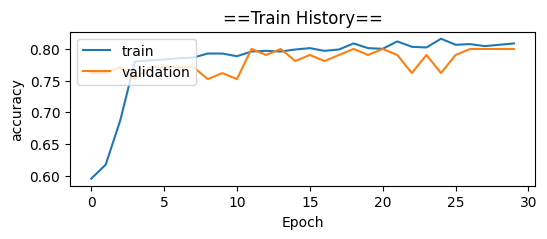

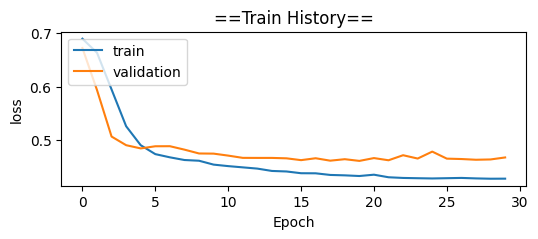

In [8]:
import matplotlib.pyplot as plt
def show_train_history(history,train,validation):
  plt.figure(figsize=(6,2))
  plt.plot(history[train]) #keras物件的.history屬性
  plt.plot(history[validation])
  plt.title("==Train History==")
  plt.ylabel(train)
  plt.xlabel("Epoch")
  plt.legend(["train","validation"],loc="upper left")
  plt.show()
show_train_history(train_history.history,"accuracy","val_accuracy")
show_train_history(train_history.history,"loss","val_loss")

In [9]:
scores=model.evaluate(test_Features,test_Label) #test資料的功能就用到這裡，畢竟我們是要分析全部

9/9 [==============================] - 0s 3ms/step - loss: 0.5002 - accuracy: 0.7681


In [10]:
Jack=pd.Series([None,"Jack",3,"male",23,1,0,5.000,"S"])
Rose=pd.Series([None,"Rose",1,"female",20,1,0,100.000,"S"])
JR_df=pd.DataFrame([list(Jack),list(Rose)],columns=["survived","name","pclass","sex","age","sibsp","parch","fare","embarked"])
JR_df

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked
0,None,Jack,3,male,23,1,0,5.0,S
1,None,Rose,1,female,20,1,0,100.0,S


In [11]:
all_df=pd.concat([all_df,JR_df]) #把JR_df表格加入all_df表格末端
all_df[-3:]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked
1308,0,"Zimmerman, Mr. Leo",3,male,29.0,0,0,7.875,S
0,None,Jack,3,male,23.0,1,0,5.000,S
1,None,Rose,1,female,20.0,1,0,100.000,S


In [12]:
all_Features,all_Label=PreprocessingData(all_df)

  survived  pclass  sex   age  sibsp  parch      fare  embarked_C  embarked_Q  \
0        1       1    0  29.0      0      0  211.3375           0           0   

   embarked_S  
0           1  
資料處理完畢:Feature [1 0 29.0 0 0 211.3375 0 0 1]


In [21]:
all_probability=model.predict(all_Features)
#我們給出features(不含survived)叫AI預測所有人的生存率(包含我們新增的假腳色)

41/41 [==============================] - 0s 2ms/step


In [15]:
all_probability[:10] #第一到第十位的旅客生存機率

array([[0.9883469 ],
       [0.6962116 ],
       [0.9885131 ],
       [0.39181167],
       [0.9834551 ],
       [0.23165672],
       [0.9413714 ],
       [0.30666006],
       [0.9322883 ],
       [0.19334808]], dtype=float32)

In [22]:
d_all_df=all_df.copy() #要複製，不複製的話代表d_all_df和all_df指向同一個dataframe

In [17]:
d_all_df.insert(len(d_all_df.columns),"predicted_survived_probability",all_probability) #執行這邊以後上面會出錯(?)

In [18]:
d_all_df[-3:]
#可以看到我們模擬了虛構人物Jack和Rose兩人的資訊，AI幫我們預測兩人的生存機率

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked,predicted_survived_probability
1308,0,"Zimmerman, Mr. Leo",3,male,29.0,0,0,7.875,S,0.139394
0,None,Jack,3,male,23.0,1,0,5.000,S,0.136361
1,None,Rose,1,female,20.0,1,0,100.000,S,0.983196


In [23]:
# all_df[-3:]

In [20]:
d_all_df[(d_all_df.survived==0)&(d_all_df.predicted_survived_probability>0.9)]
#這裡我們搜尋所有AI預測出來應該要活著但事實上卻過世的人
#我們去網路上搜尋這些人的名字可以發現他們那時候感人的故事(比如說isidor婦人)
#AI真的功能非常強大

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked,predicted_survived_probability
2,0,"Allison, Miss. Helen Loraine",1,female,2.0,1,2,151.5500,S,0.988513
4,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",1,female,25.0,1,2,151.5500,S,0.983455
105,0,"Evans, Miss. Edith Corse",1,female,36.0,0,0,31.6792,C,0.987339
169,0,"Isham, Miss. Ann Elizabeth",1,female,50.0,0,0,28.7125,C,0.984391
286,0,"Straus, Mrs. Isidor (Rosalie Ida Blun)",1,female,63.0,1,0,221.7792,S,0.960916
381,0,"Corbett, Mrs. Walter H (Irene Colvin)",2,female,30.0,0,0,13.0000,S,0.905780
382,0,"Corey, Mrs. Percy C (Mary Phyllis Elizabeth Mi...",2,female,NaN,0,0,21.0000,S,0.908125
445,0,"Hiltunen, Miss. Marta",2,female,18.0,1,1,13.0000,S,0.907387
468,0,"Karnes, Mrs. J Frank (Claire Bennett)",2,female,22.0,0,0,21.0000,S,0.929592
599,0,"Yrois, Miss. Henriette (""Mrs Harbeck"")",2,female,24.0,0,0,13.0000,S,0.923013
